In [1]:
import os
os.chdir("../../../")

import pandas as pd
import numpy as np

import spacy
import string
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV

# Sklearn models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

from src.text.utils import *

In [2]:
st_path = os.getcwd() + "/data/text/solomon_islands/solomon_times_news.csv"
st = pd.read_csv(st_path).drop("Unnamed: 0", axis=1)
st["tag"] = st["tag"].str.lower()
st["label"] = ["economy" in i for i in st["tag"]]

In [136]:
st[st["label"] == True]

,url,date,news,tag,ym,label
0,https://www.solomontimes.com/news/north-vella-...,2007-04-28 20:25:26,The psychological effect of the tsunami is for...,"news,economy",2007-4,True
7,https://www.solomontimes.com/news/20-year-old-...,2007-04-30 01:57:33,Last night at about 6.30pm a 20 year old girl ...,"news,economy",2007-4,True
8,https://www.solomontimes.com/news/hiv-kills-th...,2007-04-29 04:30:48,Three people infected with the HIV virus have ...,"news,economy",2007-4,True
12,https://www.solomontimes.com/news/government-r...,2007-04-27 23:30:25,"Import duties, for certain household items, ar...","news,economy",2007-4,True
14,https://www.solomontimes.com/news/720000-down-...,2007-04-28 07:40:35,With more then five government vehicles damage...,"news,economy",2007-4,True
...,...,...,...,...,...,...
11041,https://www.solomontimes.com/news/kolosori-nic...,2023-08-20 21:43:00,The Kolosori nickel project located in the Sol...,"news,economy",2023-8,True
11042,https://www.solomontimes.com/news/solomon-isla...,2023-08-13 23:12:00,The Solomon Islands Immigration Division is wa...,"news,economy",2023-8,True
11043,https://www.solomontimes.com/news/treasures-of...,2023-08-07 00:40:00,After an eventful journey across Australia's m...,"news,economy",2023-8,True
11046,https://www.solomontimes.com/news/pacific-reco...,2023-08-07 23:58:00,Despite uncertainty about the outlook for infl...,"news,economy",2023-8,True


In [3]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
spacy_stopwords = list(nlp.Defaults.stop_words)

nltk_stopwords = stopwords.words("english")
nltk_unique = [sw for sw in nltk_stopwords if sw not in spacy_stopwords]
spacy_stopwords.extend(nltk_unique)

In [4]:
def remove_punctuation(text: str):
    return "".join([i for i in text if i not in string.punctuation])

def remove_stopwords(text: str, stopwords: list):
    return "".join([i for i in text if i not in stopwords])

In [5]:
data = st.news.values.tolist()
data_words = list(sent_to_words(data))

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[data_words], min_count=5, threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_preprocessed = preprocess_text(data_words, spacy_stopwords, bigram_mod,
                                     trigram_mod, nlp)

In [7]:
st["texts"] = texts_preprocessed
st["texts"] = st["texts"].apply(lambda x: " ".join(i for i in x))
X_train, X_test, y_train, y_test = train_test_split(
    st['texts'],   
    st['label'], 
    test_size=0.1, 
    random_state=42,  
    shuffle=True)   

In [8]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [127]:
lr_tfidf = LogisticRegression(solver='liblinear', C=10, penalty='l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)

y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:, 1]


print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

       False       0.76      0.70      0.73       521
        True       0.75      0.81      0.78       584

    accuracy                           0.76      1105
   macro avg       0.76      0.75      0.75      1105
weighted avg       0.76      0.76      0.75      1105

Confusion Matrix: [[364 157]
 [113 471]]
AUC: 0.8268806036862726


In [11]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100]
}

lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid = param_grid, cv=5, scoring="accuracy")
clf.fit(X_train_vectors_tfidf, y_train)
print(clf.best_params_)

/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

{'C': 1, 'penalty': 'l2'}


/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fit

In [180]:
models = [
    RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=42),
    MultinomialNB(),
    LinearSVC(random_state=42),
    LogisticRegression(solver='liblinear', C=1, penalty='l2', random_state=42),
    XGBClassifier(tree_method="hist", enable_categorical=True, random_state=42)
]

scoring = ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro']

for model in models:
    model_name = model.__class__.__name__
    result = cross_validate(model,
                            X_train_vectors_tfidf,
                            y_train,
                            cv=5,
                            scoring=scoring)
    print(
        "%s: Mean Accuracy = %.2f%%; Mean F1-macro = %.2f%%; Mean recall-macro = %.2f%%; Mean precision-macro = %.2f%%"
        % (model_name, result['test_accuracy'].mean() * 100,
           result['test_f1_macro'].mean() * 100,
           result['test_recall_macro'].mean() * 100,
           result['test_precision_macro'].mean() * 100))

RandomForestClassifier: Mean Accuracy = 62.48%; Mean F1-macro = 53.19%; Mean recall-macro = 59.32%; Mean precision-macro = 77.15%
MultinomialNB: Mean Accuracy = 74.40%; Mean F1-macro = 73.14%; Mean recall-macro = 73.14%; Mean precision-macro = 76.30%


/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  war

LinearSVC: Mean Accuracy = 75.08%; Mean F1-macro = 74.74%; Mean recall-macro = 74.63%; Mean precision-macro = 75.08%
LogisticRegression: Mean Accuracy = 77.05%; Mean F1-macro = 76.50%; Mean recall-macro = 76.32%; Mean precision-macro = 77.60%
XGBClassifier: Mean Accuracy = 75.53%; Mean F1-macro = 75.05%; Mean recall-macro = 74.90%; Mean precision-macro = 75.79%


## Prediction

In [20]:
target = os.getcwd() + "/data/text/solomon_islands/"
news_path = [filename for filename in os.listdir(target) if "news" in filename and "times" not in filename]

In [22]:
news = pd.DataFrame()
for path in news_path:
    temp = pd.read_csv(target + path).drop("Unnamed: 0", axis=1)
    temp["from"] = path.replace("_news.csv", "")
    if news.empty:
        news = temp
    else: 
        news = pd.concat([news, temp], axis=0)

news = news[news.news.isna() != True].reset_index(drop=True)

In [24]:
data = news.news.values.tolist()
data_words = list(sent_to_words(data))

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[data_words], min_count=5, threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_preprocessed = preprocess_text(data_words, spacy_stopwords, bigram_mod,
                                     trigram_mod, nlp)

Stopwords has been done.


In [62]:
news["texts"] = texts_preprocessed
news["texts"] = news["texts"].apply(lambda x: " ".join(i for i in x))
X_vectors_tfidf = tfidf_vectorizer.transform(news["texts"])

In [173]:
news["predicted_econ"] = best_mod.predict(X_vectors_tfidf)
news["econ_prob"] = xgb.predict_proba(X_vectors_tfidf)[:, 1]

In [174]:
econ_news = news[news.econ_prob >= 0.9].reset_index(drop=True)
st["tag"] = st["tag"].str.lower()
st["label"] = ["economy" in i for i in st["tag"]]
st_econ = st[st.label == True].reset_index(drop=True)
econ_news = pd.concat([st[["date", "news"]], econ_news[["date", "news"]]]).reset_index(drop=True)
econ_news["date"] = pd.to_datetime(econ_news["date"])
econ_news

,date,news
0,2007-04-28 20:25:26,The psychological effect of the tsunami is for...
1,2007-04-30 02:00:40,The British High Commission Office in Honiara ...
2,2007-04-30 21:01:39,"Afu Billy, the regional director of the common..."
3,2007-04-30 20:37:59,"Ken Averre, Director of the Public Prosecution..."
4,2007-04-30 12:29:00,A public forum was today organized by the Offi...
...,...,...
12556,2023-04-03 00:00:00,Health authorities sound alarmBY MAVIS N PODOK...
12557,2023-05-11 00:00:00,BY NED GAGAHESolomon Airlines has successfully...
12558,2023-05-11 00:00:00,Objectives in national development strategy ac...
12559,2023-06-01 00:00:00,"Two people trapped in Anthony Saru elevator, r..."


In [175]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_df = pd.DataFrame()
for row in econ_news.news:
    sample = row.replace("\n", " ").strip()
    
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(sample)
    ss_temp = pd.DataFrame(ss, columns=ss.keys(), index=[0])
    sent_df = pd.concat([sent_df, ss_temp], axis=0)

In [176]:
econ_news["sentiment"] = sent_df["compound"].tolist()
econ_sent = econ_news.set_index("date").groupby(pd.Grouper(freq="M"))[["sentiment"]].mean().reset_index()

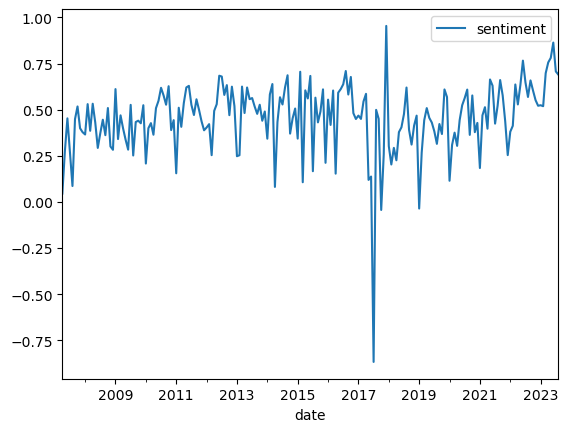

In [177]:
econ_sent.plot(x="date", y="sentiment");